### <div dir="rtl" style="font-family: 'Segoe UI', Tahoma, sans-serif; font-size: 30px; color: #ffffff; font-weight: bold; padding: 10px; border-radius: 8px; background: linear-gradient(135deg, #2EA149, #60a5fa); text-align: right;"> مهندسی ویژگی</div>


In [15]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import textblob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import nltk

import re


In [16]:
#loading data
train =pd.read_csv(r"D:\AI Bootcamp\Project2\NLP\merged_df.csv")

### <div dir="rtl" style="font-family: 'Segoe UI', Tahoma, sans-serif; font-size: 20px; color: #ffffff;  padding: 10px; border-radius: 8px; background: linear-gradient(135deg, #2EA149, #60a5fa); text-align: right;"> بررسی ارتباط ستون های verified,overall, vote</div>


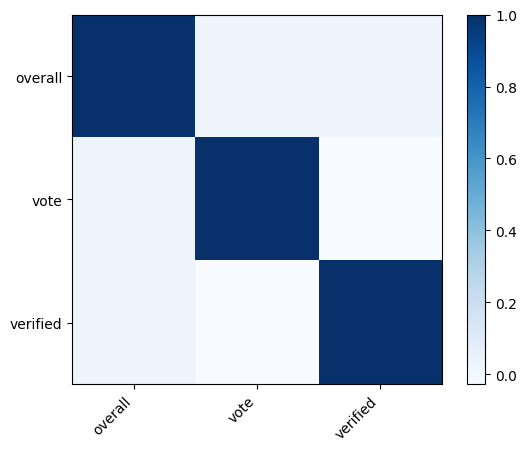

In [17]:
df1= train.drop(columns=[ 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'review_length', 'title', 'brand'])
matrix = df1.corr()

# plotting correlation matrix
plt.imshow(matrix, cmap='Blues')

# adding colorbar
plt.colorbar()

# extracting variable names
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Display the plot
plt.show()

### <div dir="rtl" style="font-family: 'Segoe UI', Tahoma, sans-serif; font-size: 20px; color: #ffffff;  padding: 10px; border-radius: 8px; background: linear-gradient(135deg, #2EA149, #60a5fa); text-align: right;"> به دلیل همبستگی پایین با نمره، دو ستون دیگر میتوانند از آموزش حذف شوند</div>


In [18]:
train= train.drop(columns=[ 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'unixReviewTime',
       'review_length', 'title', 'brand','vote','verified'])

In [19]:
#checking for null values
train.isna().sum()

overall        0
reviewText     0
summary       78
dtype: int64

In [20]:
# dropping null values
train= train.dropna()
train.isna().sum()

overall       0
reviewText    0
summary       0
dtype: int64

### <div dir="rtl" style="font-family: 'Segoe UI', Tahoma, sans-serif; font-size: 20px; color: #ffffff;  padding: 10px; border-radius: 8px; background: linear-gradient(135deg, #2EA149, #60a5fa); text-align: right;"> آماده سازی توابع پردازش متن</div>


In [21]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-dat

True

In [22]:


# before we get to feature engineering and tampering with words, we need to define the words we want to keep and contractions

words_to_keep = {
    "good", "bad", "perfect",'great', "poor","nice", "amazing", "disappointing", "excellent", 
    "terrible", "great", "awful", "best", "worst", "nice", "love", "hate", "confident","service",
    "recommend", "quality", "worth", "value", "works", "needs", "lasts", "ordinary", "successful","unsuccessful"
    "charges", "holds", "fits", "connects", "easy", "hard", "fast", "slow", "insult",
    "durable", "price", "money", "buy", "purchase", "waste", "deal", "cost", "cancel",
    "return", "refund", "replace", "remote", "tablet", "charger", "cord", "level","fail","finally",
    "cable", "battery", "screen", "URC", "Roku", "garantee", "warranty","common","experience"
}

contractions = {
    "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are",
    "'s": " is", "'d": " would", "'ll": " will", "'t": " not",
    "'ve": " have", "'m": " am", "it's": "it is", "that's": "that is",
    "there's": "there is", "here's": "here is", "what's": "what is",
    "who's": "who is", "how's": "how is", "i've": "i have", "you've": "you have",
    "they've": "they have", "we've": "we have", "i'd": "i would", "you'd": "you would",
    "he'd": "he would", "she'd": "she would", "they'd": "they would",
    "i'll": "i will", "you'll": "you will", "he'll": "he will", "she'll": "she will",
    "we'll": "we will", "they'll": "they will", "isn't": "is not", "aren't": "are not",
    "wasn't": "was not", "weren't": "were not", "haven't": "have not",
    "hasn't": "has not", "hadn't": "had not", "doesn't": "does not",
    "don't": "do not", "didn't": "did not", "won't": "will not",
    "wouldn't": "would not", "can't": "cannot", "couldn't": "could not",
    "shouldn't": "should not", "mightn't": "might not", "mustn't": "must not"
}

# Important stopwords to retain for sentiment
important_stopwords = {"not", "no", "never", "very", "all", "any", "some", "none", "only", "too", "quite", "most", "more", "less"}

# Words indicating negation
negation_words = {"not", "no", "never", "none", "nothing", "nobody", "neither", "nowhere", "hardly", "scarcely", "barely", "without", "doesn’t", "isn’t", "wasn’t", "shouldn’t", "wouldn’t", "couldn’t", "don’t", "can’t", "didn’t"}


# Load data
data = train

# Combine 'summary' and 'reviewText' into a single text column
data['text'] = data['summary'].fillna('') + " " + data['reviewText'].fillna('')

# Define preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    # 1. Lowercase text
    text = text.lower()
    
    # 2. Expand contractions
    for contraction, expanded in contractions.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expanded, text)

    # 3. Remove punctuation (keeping sentiment-relevant symbols if needed)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # 4. Handle repeated characters (e.g., "soooo good" -> "so good")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # Reduces characters occurring 3+ times to 2 (e.g., "loooove" -> "loove")
    
    # 5. Tokenize
    tokens = word_tokenize(text)
    
    # 6. Remove stopwords while keeping important ones for sentiment or in `words_to_keep`
    tokens = [
        word for word in tokens 
        if word not in stop_words or word in important_stopwords or word in words_to_keep
    ]

    # 7. Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # 8. Emphasize negations (e.g., "not good" becomes "not good_NEG")
    emphasized_tokens = []
    negate = False
    
    for token in tokens:
        if token in negation_words:
            negate = True
            emphasized_tokens.append(token)
        elif negate:
            emphasized_tokens.append(f"{token}_NEG")
            negate = False
        else:
            emphasized_tokens.append(token)

    # 9. Rejoin tokens into processed text
    processed_text = " ".join(emphasized_tokens)
    
    return processed_text

# Apply preprocessing
data['text'] = data['text'].apply(preprocess_text)

# Split data
X = data['text']
y = data['overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\USER/nltk_data'
    - 'c:\\Program Files\\Python312\\nltk_data'
    - 'c:\\Program Files\\Python312\\share\\nltk_data'
    - 'c:\\Program Files\\Python312\\lib\\nltk_data'
    - 'C:\\Users\\USER\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


### <div dir="rtl" style="font-family: 'Segoe UI', Tahoma, sans-serif; font-size: 30px; color: #ffffff; font-weight: bold; padding: 10px; border-radius: 8px; background: linear-gradient(135deg, #2EA149, #60a5fa); text-align: right;"> مدلسازی</div>


### <div dir="rtl" style="font-family: 'Segoe UI', Tahoma, sans-serif; font-size: 20px; color: #ffffff;  padding: 10px; border-radius: 8px; background: linear-gradient(135deg, #2EA149, #60a5fa); text-align: right;"> مدل Logestic Regression</div>


In [ ]:
# Define a pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 3))),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000))
])

# Fit model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred, average='micro')
print(f"F1 Score (Micro Averaged): {f1:.4f}")


F1 Score (Micro Averaged): 0.7103


In [ ]:
# count of different values in column averall
data.overall.value_counts()

overall
5    461485
4    156514
1     82950
3     81239
2     56756
Name: count, dtype: int64

In [ ]:

#
def sampling(df, num_target, each_class_size):
    min_class_size = min(each_class_size, df[num_target].value_counts().min())
    balanced_df = pd.concat([
        df[df[num_target] == sentiment].sample(min_class_size, replace=True)
        for sentiment in df[num_target].unique()
    ])
    return balanced_df.sample(frac=1).reset_index(drop=True)

# Balance the entire dataset
balanced_data = sampling(data, num_target='overall', each_class_size=200000)  # Set each_class_size as desired

balanced_data.overall.value_counts()

overall
1    56756
3    56756
5    56756
2    56756
4    56756
Name: count, dtype: int64

In [ ]:
# Split balanced data
X1 = balanced_data['text']
y1 = balanced_data['overall']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=0)

# Define and train pipeline
pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 3))),
    ('clf', LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs', max_iter=10000))
])

pipeline1.fit(X_train1, y_train1)

# Predict and evaluate
y_pred1 = pipeline1.predict(X_test1)
f1 = f1_score(y_test1, y_pred1, average='micro')
print(f"F1 Score (Micro Averaged): {f1:.4f}")
print(classification_report(y_test1, y_pred1))

F1 Score (Micro Averaged): 0.6050
              precision    recall  f1-score   support

           1       0.67      0.71      0.69     11300
           2       0.53      0.51      0.52     11279
           3       0.52      0.50      0.51     11491
           4       0.58      0.55      0.56     11374
           5       0.70      0.76      0.73     11312

    accuracy                           0.61     56756
   macro avg       0.60      0.61      0.60     56756
weighted avg       0.60      0.61      0.60     56756



In [ ]:


# Assuming data has already been preprocessed and split
X_train2, X_test2, y_train2, y_test2 = train_test_split(data['text'], data['overall'], test_size=0.2, random_state=42)

# Define pipeline with SMOTE and Logistic Regression with class weights
pipeline2 = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
    ('smote', SMOTE(random_state=42)),  # Oversample minority classes
    ('clf', LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs', max_iter=5000))
])

# Fit the model
pipeline2.fit(X_train2, y_train2)

# Predict and evaluate
y_pred2 = pipeline2.predict(X_test2)
f1 = f1_score(y_test2, y_pred2, average='micro')
print(f"F1 Score (Micro Averaged): {f1:.4f}")
print(classification_report(y_test2, y_pred2))


In [ ]:


# Custom Transformer to add text length features
class TextLengthExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return np.array([[len(text.split()), len(text)] for text in data])

# Custom Transformer to add sentiment score
class SentimentExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return np.array([textblob.TextBlob(text).sentiment.polarity for text in data]).reshape(-1, 1)

# Build pipeline with TF-IDF, additional features, and Gradient Boosting
pipeline3 = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 2), stop_words='english')),
        ('text_length', TextLengthExtractor()),
        ('sentiment', SentimentExtractor())
    ])),
    ('clf', GradientBoostingClassifier())
])

# Define hyperparameters to tune
param_grid = {
    'features__tfidf__max_features': [10000, 20000, 30000],
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.1, 0.05],
    'clf__max_depth': [3, 5]
}

# Grid search for best hyperparameters
grid_search = GridSearchCV(pipeline3, param_grid, scoring='f1_micro', cv=3, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Predict and evaluate
y_pred3 = grid_search.predict(X_test)
f1 = f1_score(y_test, y_pred3, average='micro')
print(f"Best F1 Score (Micro Averaged): {f1:.4f}")
print("Best Parameters:", grid_search.best_params_)


In [ ]:


# Define a pipeline with CountVectorizer and Logistic Regression
pipeline4 = Pipeline([
    ('count_vec', CountVectorizer(max_features=20000, ngram_range=(1, 3))),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000))
])

# Fit model
pipeline4.fit(X_train, y_train)

# Predict and evaluate
y_pred4 = pipeline4.predict(X_test)
f1 = f1_score(y_test, y_pred4, average='micro')
print(f"F1 Score (Micro Averaged): {f1:.4f}")


In [ ]:
test_data = pd.read_csv('test_data.csv')
test_data['text'] = test_data['reviewText'].fillna('').apply(preprocess_text)



In [ ]:
# Predict on test data
test_predictions = pipeline1.predict(test_data['text'])

# Create a DataFrame for submission
submission = pd.DataFrame({
    'reviewerID': test_data['reviewerID'],  # Adjust this column based on test data format
    'predicted_score': test_predictions
})

# Save submission to a CSV file without an index, as per your requirement
submission.to_csv('q2_submission.csv', index=False)

In [ ]:
import numpy as np


size = test_predictions.size

# Number of unique elements
num_unique = len(np.unique(test_predictions))

print("Size of the array:", size)
print("Number of unique elements:", num_unique)

Size of the array: 20000
Number of unique elements: 5


In [ ]:

# Create a DataFrame from the predictions
predictions_df = pd.DataFrame(test_predictions, columns=['predicted'])

# Save the DataFrame to a CSV file
predictions_df.to_csv('q2_submission.csv', index=False)
predictions_df

,predicted
0,3
1,1
2,2
3,1
4,1
...,...
19995,5
19996,5
19997,5
19998,2
